In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import time
import matplotlib.pyplot as plt

In [16]:
# definition of the leaky hardtanh function
def leaky_hardtanh(input, min_val=- 1.0, max_val=1.0, min_slope=0.01, max_slope=0.01):
    '''
        Defines the Leaky Hardtanh function
    '''
    return torch.where(input < max_val, F.leaky_relu(input-min_val, min_slope)+min_val, (input-max_val)*max_slope+max_val)

# create a class wrapper from PyTorch nn.Module
class LeakyHardtanh(nn.Module):
    r"""Applies the Leaky HardTanh function element-wise.

    Leaky HardTanh is defined as:

    .. math::
        \text{LeakyHardTanh}(x) = \begin{cases}
            (x - \text{max\_val}) \ times x +  \text{max\_val} & \text{ if } x > \text{ max\_val } \\
            (x - \text{min\_val}) \ times x +  \text{min\_val} & \text{ if } x < \text{ min\_val } \\
            x & \text{ otherwise } \\
        \end{cases}

    Args:
        min_val: minimum value of the linear region range. Default: -1
        max_val: maximum value of the linear region range. Default: 1
        min_slope: Controls the angle of the region below min_val. Default: 0.01
        max_slope: Controls the angle of the region above max_val. Default: 0.01

    Shape:
        - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
        - Output: :math:`(*)`, same shape as the input.

    Examples::

        >>> m = nn.LeakyHardtanh(-2, 2, 0.001, 0.001)
        >>> input = torch.randn(2)
        >>> output = m(input)
    """
    def __init__(self, min_val: float =- 1.0, max_val: float=1.0, min_slope: float=0.01, max_slope: float=0.01):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
        self.min_slope = min_slope
        self.max_slope = max_slope
        assert self.max_val > self.min_val, "max_val must be larger than min_val"

    def forward(self, input: Tensor) -> Tensor:
        return leaky_hardtanh(input, self.min_val, self.max_val, self.min_slope, self.max_slope)

0.0007481575012207031


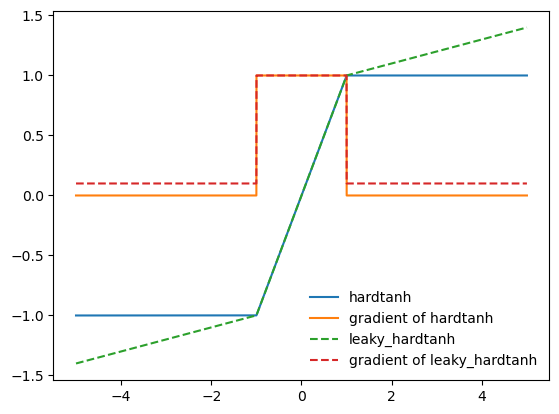

In [17]:
x = torch.linspace(-5, 5, 100_000, requires_grad=True)
x2 = torch.linspace(-5, 5, 100_000, requires_grad=True)

act = LeakyHardtanh(min_val=-1.0, max_val=1, min_slope=0.1, max_slope=0.1)
s_time = time.time()
y = act(x)
print(time.time()-s_time)
hardtanh = nn.Hardtanh(min_val=-1, max_val=1.)
hardy = hardtanh(x2)
y.sum().backward()
hardy.sum().backward()


# plot

plt.plot(x2.detach().numpy(), hardy.detach().numpy(), label='hardtanh')
plt.plot(x2.detach().numpy(), x2.grad.detach().numpy(), label='gradient of hardtanh')

plt.plot(x.detach().numpy(), y.detach().numpy(), label='leaky_hardtanh', linestyle='--')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label='gradient of leaky_hardtanh', linestyle='--')

plt.legend(loc='lower right', edgecolor='none')
plt.show()

0.0001423358917236328


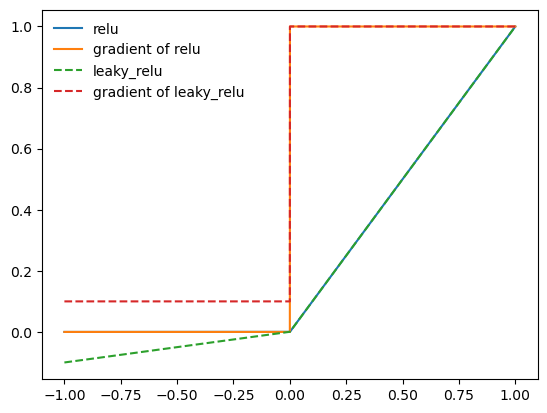

In [4]:
x = torch.linspace(-1, 1, 100_000, requires_grad=True)
x2 = torch.linspace(-1, 1, 100_000, requires_grad=True)

relu = nn.ReLU()
lrelu = nn.LeakyReLU(negative_slope=0.1)
y = relu(x)
s_time = time.time()
y2 = lrelu(x2)
print(time.time()-s_time)
y.sum().backward()
y2.sum().backward()


# plot

plt.plot(x.detach().numpy(), y.detach().numpy(), label='relu')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label='gradient of relu')

plt.plot(x2.detach().numpy(), y2.detach().numpy(), label='leaky_relu', linestyle='--')
plt.plot(x2.detach().numpy(), x2.grad.detach().numpy(), label='gradient of leaky_relu', linestyle='--')

plt.legend(loc='upper left', edgecolor='none')
plt.show()

# test timing

In [5]:
x = torch.randn(size=(1000,1000,10), requires_grad=True, device='cuda')

act = LeakyHardtanh(min_val=-1.0, max_val=1.0, max_slope=0.1, min_slope=0.1)
s_time = time.time()
for _ in range(100):
    y = act(x)
print(time.time()-s_time)

0.09009075164794922


In [6]:
x = torch.randn(size=(1000,1000,10), requires_grad=True, device='cuda')

act = nn.LeakyReLU()
s_time = time.time()
for _ in range(100):
    y = act(x)
print(time.time()-s_time)

0.002328634262084961


In [7]:
# --> about 7x slower than leakyrelu